In [6]:
from sklearn.svm import SVC

# Load data.
X = [[2400, 51], [2500, 32], [2650, 103], [2450, 174]]
y = [  'sand',     'sand',     'shale',     'shale']

# Train model.
svc = SVC(kernel='linear')
svc.fit(X, y)

# New data.
X_new = [[2550, 65]]

# Predict.
print(svc.predict(X_new))

['sand']


In [1]:
import numpy as np

np.set_printoptions(suppress=True)

# Mis-steps in machine learning

---
### We will do this notebook from scratch in class; we're unlikely to get to all of it.
---

First we'll import some data. I'm using an extract from the Rock Property Catalog, https://subsurfwiki.org/wiki/Rock_Property_Catalog

In [1]:
import pandas as pd

df = pd.read_csv("~/Desktop/RPC_basic.csv")

df.head()

,Vp,Vs,Rho_n,pay
0,3045.6,1595.7,2109.120585,True
1,3000.6,1517.1,2090.342013,True
2,3363.6,2041.5,2131.989982,True
3,3195.3,1606.2,2184.939233,True
4,4237.5,2448.6,2472.230768,True


<AxesSubplot:xlabel='Vp', ylabel='Rho_n'>

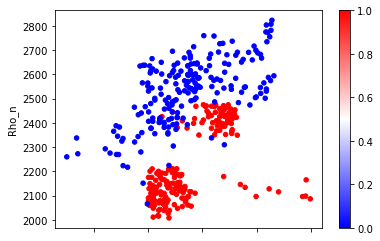

In [2]:
df.plot.scatter('Vp', 'Rho_n', c=df.pay, cmap='bwr')

In [5]:
import pandas

pandas.__version__

'1.2.4'

In [3]:
X = df[['Vp', 'Rho_n']].values
y = df.Lithology.values

In [4]:
X[:10]

array([[3045.6       , 2109.12058533],
       [3000.6       , 2090.34201313],
       [3363.6       , 2131.98998202],
       [3195.3       , 2184.93923335],
       [4237.5       , 2472.23076759],
       [4319.1       , 2458.95970795],
       [4533.        , 2397.13643415],
       [3538.5       , 2047.36213075],
       [3524.7       , 2210.52878324],
       [3565.2       , 2141.62021745]])

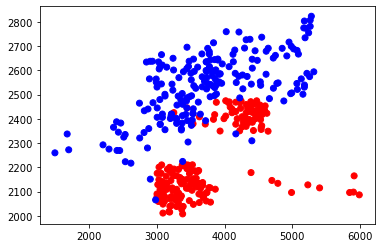

In [5]:
import matplotlib.pyplot as plt

plt.scatter(*X.T, c=y=='sandstone', cmap='bwr')

Could turn that awkward boolean into a function:

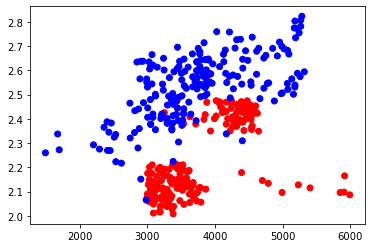

In [7]:
def is_sand(y):
    return y == 'sandstone'

plt.scatter(*X.T, c=is_sand(y), cmap='bwr')

## A linear model: SVM


### Instructor: briefly explain what an SVM does

In [8]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')

svc.fit(X, y)

y_pred = svc.predict(X_new)

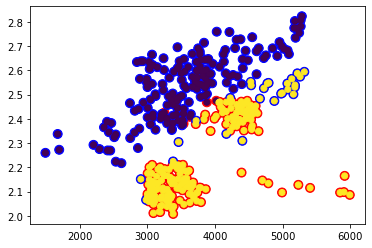

In [9]:
plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.92

<div class="alert alert-success" style="padding-bottom:2em;">

<h2>❓What do we think of this?</h2>

</div>

## Problems and solutions

There are a few issues with what we've done. Some of the issues to bring out in discussion are:

- Validation
- Model selection
- Model tuning
- Standardization


### Validation

We only tested the model performance against the training data. Some things are hard to validate (e.g. not having much data, or unsupervised learning), but we have quite a bit of data. What could we do about it?

Split off the first 300 rows:

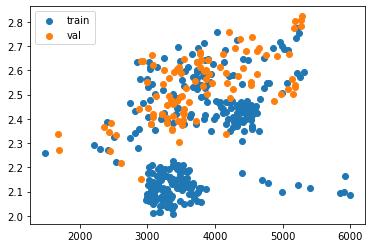

In [11]:
X_train, X_val = X[:300], X[300:]
y_train, y_val = y[:300], y[300:]

plt.scatter(*X_train.T, label='train')
plt.scatter(*X_val.T, label='val')
plt.legend()

That's no good. The validation data (orange) does not contain any sandstone at all:

In [12]:
y_val == 'sandstone'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

So let's use a random split instead:

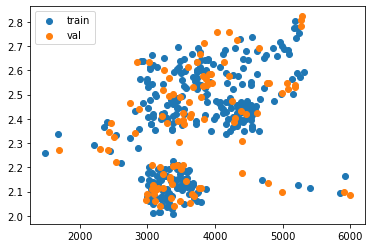

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

plt.scatter(*X_train.T, label='train')
plt.scatter(*X_val.T, label='val')
plt.legend()

❓Can you think of an occasion when a random split might not be okay?

Not surprisingly, our model gets a bit worse (we used less data to train), but maybe we trust it more.

0.88


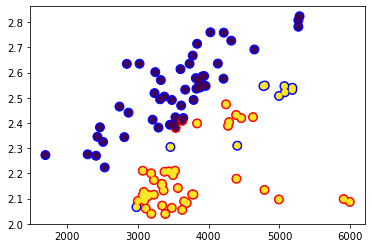

In [14]:
svc = SVC(kernel='linear')

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(accuracy_score(y_val, y_pred))

plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))

---

### Poor model

Notice that the model is linear (look carefully at the boundary). A nonlinear model should do better:

0.54


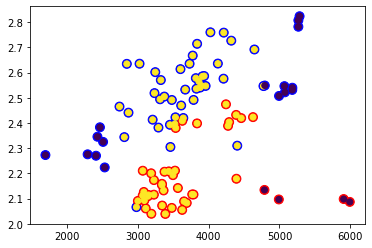

In [15]:
svc = SVC()  # Default is kernel='rbf'

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(accuracy_score(y_val, y_pred))

plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))

It doesn't... why not?

(1265.59752335, 6218.11440365, 1.9671286638887755, 2.8640572125634542)

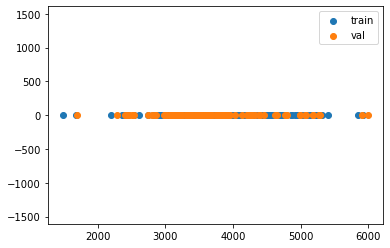

In [16]:
plt.scatter(*X_train.T, label='train')
plt.scatter(*X_val.T, label='val')
plt.legend()
plt.axis('equal')  # <-- So we can see the true data space.

---

### Standardization

We gave the model our raw data. We just about get away with it with the linear model, but any algorithms that depend on distance — either in the learning algorithm, or the cost function, or in regularization — would prefer to have standardized data. That way, they work in 'Z-score' space.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [18]:
svc = SVC(kernel='linear', probability=True)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(accuracy_score(y_val, y_pred))

0.88


In [19]:
svc = SVC(kernel='rbf', probability=True)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(accuracy_score(y_val, y_pred))

0.95


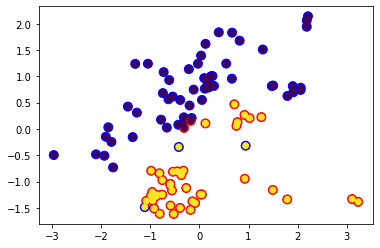

In [20]:
plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))

---

### Untuned model

We didn't try to adjust hyperparameters to get a better fit. Turns out, if you do this, the model does better with a different value for `C`:

In [31]:
svc = SVC(C=10.0)

0.96


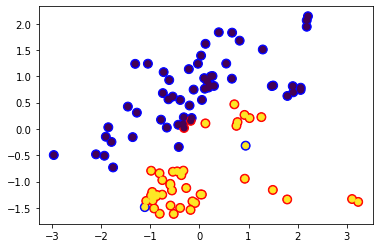

In [32]:
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)

print(accuracy_score(y_val, y_pred))

plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))

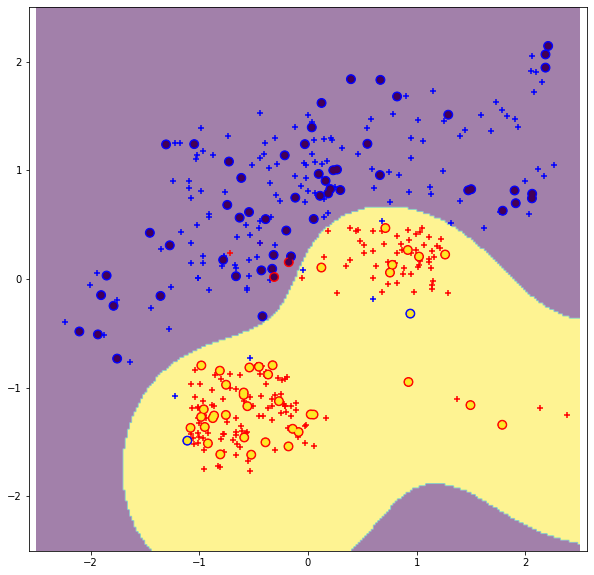

In [33]:
from utils import decision_regions

extent = [-2.5, 2.5, -2.5, 2.5]
y_pred, y_all = decision_regions(svc, X_val, y_val, extent, step=0.02)
    
plt.figure(figsize=(10, 10))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X_train.T, c=is_sand(y_train), marker='+', cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))
plt.axis('equal')
plt.xlim(-2.5, 2.5); plt.ylim(-2.5, 2.5)
plt.show()

This is pretty good. There are still some gotchas though:

- A few hundred records is not much data; we should be careful about where we apply this model.
- We have only tried one model type, and have not tuned all of its hyperparameters.
- As we add more features, we have to remember the curse of dimensionality.
- As we try more things, we need to start using a `test` dataset.

---
&copy; 2021 Agile Scientific CC-BY